#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [49]:
!pip install opendp==0.4

In [50]:
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from opendp.meas import *
from opendp.trans import *
from opendp.typing import *
from opendp.mod import enable_features, Transformation, Measurement
enable_features("contrib", "floating-point")

np.random.seed(123)
n_sims = 10000
n_samples = 10
k_att = 100

Then, define utility functions for simulating data and calculating the test statistics:


In [51]:
def synthesize(population_prob, n=1):
    rand_vec = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    return rand_vec

def test_homer(alice, sample_mean, population_mean):
    homer_test_statistic = sum(abs(alice - population_mean) - abs(alice - sample_mean))
    return homer_test_statistic


def test_dwork(alice, sample_mean, population_mean):
    dwork_test_statistic = sum((alice - population_mean) * (sample_mean - population_mean))
    return dwork_test_statistic


def null_distribution(fun, population_prob, population_mean, null_sims = 1000, alpha = 0.05):
    temp = []
    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        temp.append(fun(null_alice, sample_mean, population_mean))
    null_vals = np.sort(temp)[::-1]
    return null_vals, null_vals[round(alpha * null_sims)]

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [52]:
def graph_func(x, critic_value, title_txt = 'PDF of Null distribution'):
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)
    plt.fill_between(support[support < critic_value], densities[support < critic_value])
    plt.fill_between(support[support >= critic_value], densities[support >= critic_value])
    plt.axvline(x = critic_value)
    plt.text(x = critic_value, y = 0.9 * max(densities), s =" IN", horizontalalignment ='left')
    plt.text(x = critic_value, y = 0.9 * max(densities), s ="OUT ", horizontalalignment = 'right')
    plt.text(x = critic_value, y = 0.85 * max(densities), s = f' {(x > critic_value).mean():.2}', horizontalalignment = 'left')
    plt.title(title_txt)
    plt.xlabel("Test statistic")
    plt.ylabel("Probability density")
    plt.show()

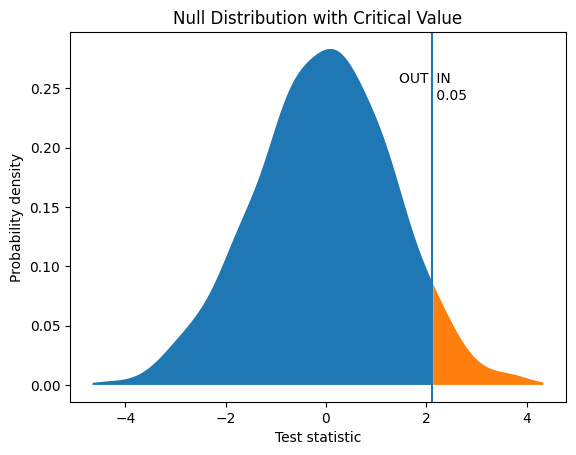

In [53]:
pop_prob = np.random.uniform(size = k_att)
test_vals, critic_val = null_distribution(test_homer, pop_prob, pop_prob)
graph_func(test_vals, critic_val, title_txt="Null Distribution with Critical Value")
plt.show()

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

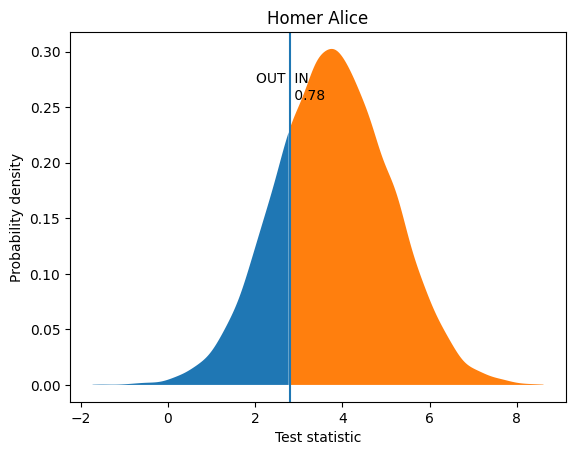

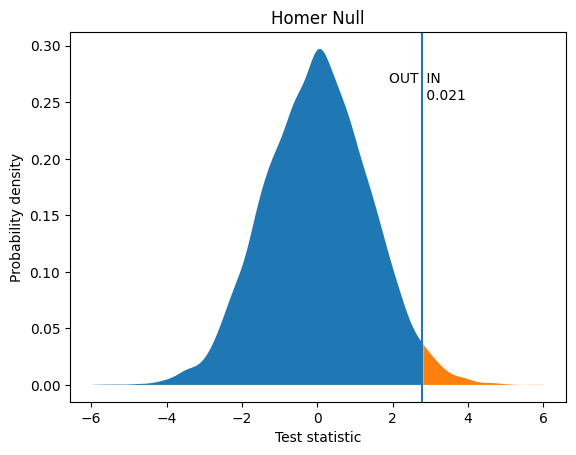

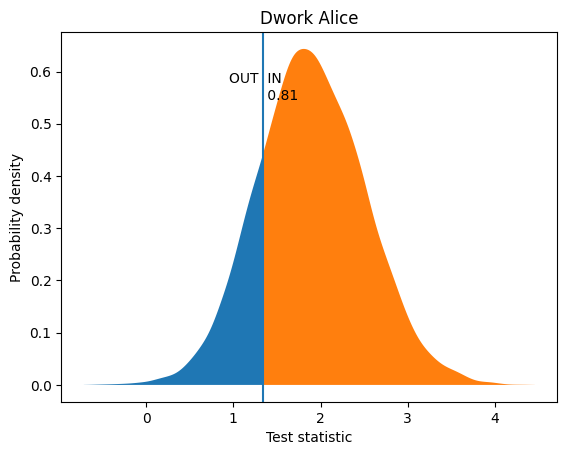

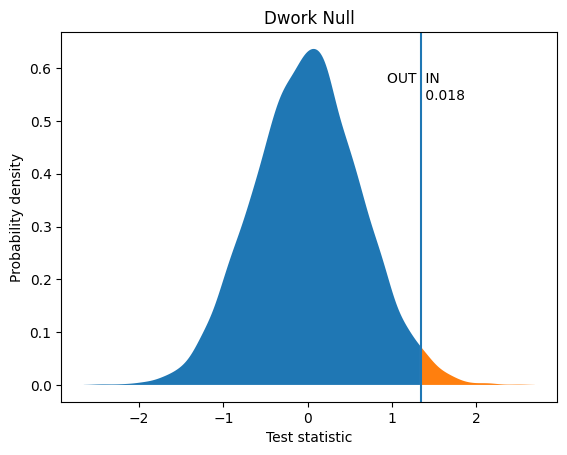

In [54]:
alpha = 0.02
simulations = np.zeros(shape=(n_sims, 4))

null_homer = null_distribution(test_homer, pop_prob, pop_prob, alpha = alpha)
null_dwork = null_distribution(test_dwork, pop_prob, pop_prob, alpha = alpha)

for i in range(n_sims):
    sample = synthesize(pop_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(pop_prob, n=1)[0]
    simulations[i, :] = [
        # homer
        test_homer(alice=alice, sample_mean=sample_mean, population_mean = pop_prob),
        test_homer(alice=null_alice, sample_mean=sample_mean, population_mean = pop_prob),
        # dwork
        test_dwork(alice=alice, sample_mean=sample_mean, population_mean = pop_prob),
        test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean = pop_prob)]

graph_func(simulations[:, 0], null_homer[1], "Homer Alice")
graph_func(simulations[:, 1], null_homer[1], "Homer Null")
graph_func(simulations[:, 2], null_dwork[1], "Dwork Alice")
graph_func(simulations[:, 3], null_dwork[1], "Dwork Null")




---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [55]:
def laplace(loc = 0., scale = 1., size = None):
    return np.random.laplace(loc = loc, scale = scale, size = size)

def dclip(x, lower_bound, upper_bound):
    return np.clip(x, lower_bound, upper_bound)

def bounded_mean(x, lower_bound, upper_bound):
    return np.mean(dclip(x, lower_bound, upper_bound))

def release_dp_mean(x, lower_bound, upper_bound, epsilon):
    return laplace(loc = bounded_mean(x, lower_bound, upper_bound), scale=(upper_bound - lower_bound) / (len(x) * epsilon))

Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [56]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")
data_len = len(data)

pums = data['educ'].values.astype(float)
print(release_dp_mean(pums, lower_bound = 1, upper_bound = 16, epsilon = 1))

10.608614115738709


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [57]:
def release_histogram(x, epsilon, categories):
    dp_histogram = np.unique(x, return_counts=True)[1] + laplace(scale = 1 / epsilon, size = len(categories))
    return dp_histogram

dp_histogram = release_histogram(pums, epsilon=1., categories = list(range(1, 17)))
print('True Histogram:')
print(np.unique(pums, return_counts=True)[1])
print('---------------------------------------------')
print('DP Private Histogram:')
print(dp_histogram)

True Histogram:
[ 272  141  357  469  497  757  894 1060 5147 1396 3964 1155 6284 2269
  795  309]
---------------------------------------------
DP Private Histogram:
[ 273.19122912  140.29404527  356.56534302  469.37529906  495.4698119
  756.45464928  893.96561021 1059.98217756 5147.06038921 1396.07750873
 3964.69125637 1153.36993322 6283.9792349  2268.48242013  795.49768221
  311.30200825]


Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [58]:
sim_results = []
num_simulations = 1000
num_range = list(range(100,2001,100))
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1]

for epsilon_sim in tqdm(epsilon_range):
    for n_sim in num_range:
        SSE = 0
        for k in range(num_simulations):
            bootdata = np.random.choice(pums, n_sim)
            sensitive_mean = bounded_mean(x = bootdata, lower_bound = 1, upper_bound = 16)
            dp_mean = release_dp_mean(x = bootdata, lower_bound = 1, upper_bound = 16, epsilon=epsilon_sim)
            SSE += (dp_mean - sensitive_mean) ** 2
        sim_results.append([n_sim, epsilon_sim, np.sqrt(SSE/num_simulations)])

100%|██████████| 7/7 [00:53<00:00,  7.59s/it]


Now graph your resluts!

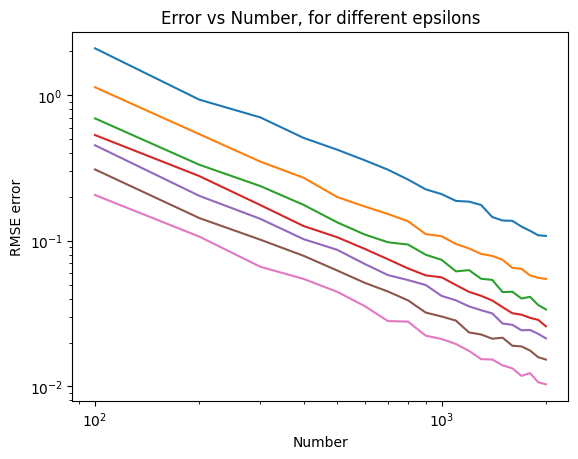

In [62]:
plt.xscale("log")
plt.yscale("log")
plt.ylabel("RMSE error")
plt.xlabel("Number")


plt.title('Error vs Number, for different epsilons')
for epsilon_sim, sim in pd.DataFrame(sim_results, columns=["num", "epsilon", "RMSE"]).groupby("epsilon"):
  plt.plot(sim['num'], sim['RMSE'])




---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [63]:
scale = 0.5
base_laplace: Measurement = make_base_laplace(scale=scale)
base_laplace(arg=23.)
sized_bounded_mean: Transformation = make_sized_bounded_mean(size = data_len, bounds = (1., 16.))
sized_bounded_mean(arg = pums)

10.608553908251183

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [64]:
dp_mean: Measurement = sized_bounded_mean >> base_laplace
dp_mean(arg = pums)

10.567162812900888

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [65]:
# Check that when sensitivity is 0.2, the privacy usage is .40
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [66]:
base_laplace.check(d_in=.16, d_out=.3)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [67]:
print(base_laplace.check(d_in=.15, d_out=.31))
print(base_laplace.check(d_in=.14, d_out=.30))
sized_bounded_mean.check(d_in=1, d_out=.15)

True
True


True

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [68]:
dp_mean.check(d_in=1, d_out=.3)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [69]:
help(make_count_by_categories)

Help on function make_count_by_categories in module opendp.trans:

make_count_by_categories(categories: Any, MO: opendp.typing.SensitivityMetric = 'L1Distance<i32>', TIA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = None, TOA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = 'i32') -> opendp.mod.Transformation
    Make a Transformation that computes the number of times each category appears in the data. 
    This assumes that the category set is known.
    
    :param categories: The set of categories to compute counts for.
    :type categories: Any
    :param MO: output sensitivity metric
    :type MO: SensitivityMetric
    :param TIA: categorical/hashable input type. Input data must be Vec<TIA>.
    :type TIA: RuntimeTypeDescriptor
    :param TOA: express counts in terms of this numeric type
    :type TOA: RuntimeTypeDescriptor
    :return: A count_by_catego

In [70]:
# release a histogram with laplace noise
dp_histogram_laplace = (
    make_count_by_categories(categories = list(range(1, 17)), TOA=float, MO=L1Distance[float]) >>
    make_base_laplace(scale=1., D=VectorDomain[AllDomain[float]])
)
dp_histogram_laplace(pums.astype(np.int32))


[274.13354025953646,
 141.40914333671475,
 354.13617104703695,
 468.43869588435723,
 497.04525088545256,
 756.7444190372755,
 890.798501248687,
 1061.5501420791165,
 5147.009417642338,
 1395.069841706246,
 3965.1941379820746,
 1154.4867977529364,
 6283.693422330567,
 2268.3967695754013,
 796.5817884950776,
 308.8083652386482,
 -0.6243097873876301]

In [71]:
# release a histogram with geometric noise
dp_histogram_geometric = (
    make_count_by_categories(categories=list(range(1, 17))) >>
    make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])
)
dp_histogram_geometric(pums.astype(np.int32))

[266,
 142,
 356,
 469,
 498,
 757,
 895,
 1056,
 5147,
 1396,
 3964,
 1158,
 6284,
 2269,
 794,
 313,
 -2]



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [72]:
# established in previous lectures
#from mock_dp_library import *
def gaussian(loc = 0., scale = 1., size = None):
    draws = np.random.normal(loc = loc, scale = scale, size = size)
    return draws

def release_dp_mean(x, lower_bound, upper_bound, epsilon, delta=1e-6, mechanism="laplace"):
    n = len(x)
    sensitivity = (upper_bound - lower_bound) / n
    return laplace(loc = bounded_mean(x = x, lower_bound = 1, upper_bound = 16), scale = sensitivity/epsilon)
    return gaussian(loc = bounded_mean(x = x, lower_bound = 1, upper_bound = 16), scale = sensitivity/epsilon* np.sqrt(2*np.log(2/delta)))

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [73]:
data = pd.read_csv("https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")
n = len(data)

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, lower_bound = 1., upper_bound = 16., epsilon=1.))

10.609638508046531


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [74]:
my_delta = 1e-6
sim_results = []
num_simulations = 1000
num_range = list(range(100,2001,100))
epsilon_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1]

for epsilon_sim in tqdm(epsilon_range):
    for n_sim in num_range:
        SSEL = 0
        SSEG = 0
        for k in range(num_simulations):
            bootdata = np.random.choice(pums, n_sim)
            sensitive_mean = bounded_mean(x = bootdata, lower_bound = 1, upper_bound = 16)
            dp_mean_laplace = release_dp_mean(x=bootdata, lower_bound = 1., upper_bound = 16., epsilon=epsilon_sim, mechanism="laplace")
            dp_mean_gaussian = release_dp_mean(x=bootdata, lower_bound = 1., upper_bound = 16., epsilon=epsilon_sim, delta=my_delta, mechanism="gaussian")
            SSEL += (dp_mean_laplace - sensitive_mean) ** 2
            SSEG += (dp_mean_gaussian - sensitive_mean) ** 2
        sim_results.append([n_sim, epsilon_sim, np.sqrt(SSEL/num_simulations), np.sqrt(SSEG/num_simulations)])

100%|██████████| 7/7 [00:41<00:00,  5.98s/it]


And Finally Graph your result:

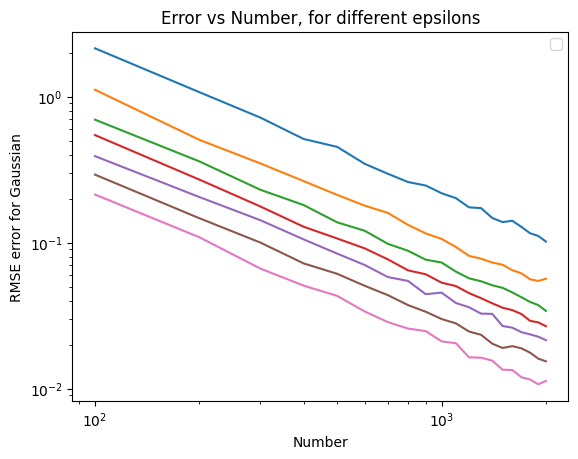

In [82]:
plt.xscale("log")
plt.yscale("log")
plt.ylabel("RMSE error for Gaussian")
plt.xlabel("Number")
plt.title('Error vs Number, for different epsilons')

for epsilon_sim, sim in pd.DataFrame(sim_results, columns=["num", "epsilon", "RMSEL", "RMSEG"]).groupby("epsilon"):
  plt.plot(sim['num'], sim['RMSEG'])


Text(0.5, 0, 'Laplacian Error')

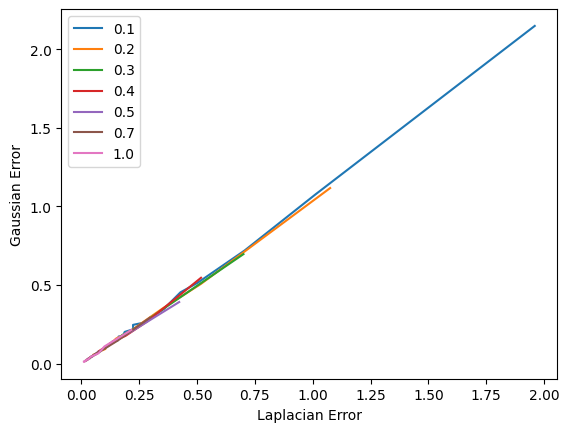

In [81]:
for epsilon_sim, sim in pd.DataFrame(sim_results, columns=["num", "epsilon", "RMSEL", "RMSEG"]).groupby("epsilon"):
    sim.plot(x="RMSEL", y="RMSEG", label = epsilon_sim, ax = plt.gca())
plt.ylabel("Gaussian Error")
plt.xlabel("Laplacian Error")